# RAG prototype

This notebook builds a langgraph that showcases the potential of a RAG agent that summarises scientific evidence from the literature and extracts statistical significant associations between pathogens and enviromental factors

#### Imports

In [74]:
import json
import os
from os.path import exists
import sqlite3
# LLM
from langchain_ollama import ChatOllama
from langchain.schema import Document, AIMessage
# to chunk the text
from langchain.text_splitter import RecursiveCharacterTextSplitter
# to make/store embeddings 
from langchain_community.vectorstores import SKLearnVectorStore
#from langchain_community.embeddings.spacy_embeddings import SpacyEmbeddings
from langchain_nomic.embeddings import NomicEmbeddings
from langchain_core.messages import HumanMessage, SystemMessage
# to build/display/run a langgraph
from langgraph.graph import StateGraph
from IPython.display import Image, display
import operator
from typing_extensions import TypedDict
from typing import List, Annotated
from langgraph.graph import END

#### Set-up the LLM

In [2]:
### llama 3.2-3b

local_llm = "llama3.2:3b-instruct-fp16"
llm = ChatOllama(model=local_llm, temperature=0)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json")

## Note: Skip to the embeddings part if you don't have the `db` file as the embeddings are run on the text contained in the database

#### Load database `db` of papers

This is the path of the `db` database containing the text extracted from the relevant papers with llamaParse

In [3]:
database_path = 'literature_relevant.db'

Define `extract_full_text_content` - this function below takes as input the SQL database and returns the full-text of the papers per page content. 

In [4]:
def extract_full_text_content(database_path):
    conn = sqlite3.connect(database_path)
    cursor = conn.cursor()

    # Retrieve all rows/papers from the table
    cursor.execute(f"SELECT fulltext FROM literature_fulltext;")
    rows = cursor.fetchall()

    # Iterate through the rows (which are papers) and extract text content
    text_content = [row[0] for row in rows if isinstance(row[0], str) and row[0] is not None]

    conn.close()

    return text_content

Extract the content below:

In [5]:
db_path = database_path
docs = extract_full_text_content(db_path)

`docs` is a list containing the full text per paper. This is not directly usable for `langchain` and it must be converted into a `Document` istance

In [33]:
docs[0]

'# Rotavirus Seasonality and Age Effects in a Birth Cohort Study of Southern India\n\n#\n# Rotavirus Seasonality and Age Effects in a Birth Cohort Study of Southern India\n\nRajiv Sarkar1, Gagandeep Kang1, Elena N. Naumova1,2*\n\n1Department of Gastrointestinal Sciences, Christian Medical College, Vellore, TN, India\n\n2Department of Civil and Environmental Engineering, Tufts University School of Engineering, Boston, Massachusetts, United States of America\n\n# Abstract\n\n# Introduction\n\nUnderstanding the temporal patterns in disease occurrence is valuable for formulating effective disease preventive programs. Cohort studies present a unique opportunity to explore complex interactions associated with emergence of seasonal patterns of infectious diseases.\n\n# Methods\n\nWe used data from 452 children participating in a birth cohort study to assess the seasonal patterns of rotavirus diarrhea by creating a weekly time series of rotavirus incidence and fitting a Poisson harmonic regres

We do this together with the splitting, by using the function `.create_documents` while splitting it, within the `RecursiveCharacterTextSplitter`

In [32]:
len(docs)

69

#### Chunk text and extract embeddings

In [67]:
documents = []

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=2000, chunk_overlap=200
)

documents = text_splitter.create_documents([text for text in docs])

In [68]:
len(documents[0].page_content)

9612

In [69]:
documents[0].page_content

'# Rotavirus Seasonality and Age Effects in a Birth Cohort Study of Southern India\n\n#\n# Rotavirus Seasonality and Age Effects in a Birth Cohort Study of Southern India\n\nRajiv Sarkar1, Gagandeep Kang1, Elena N. Naumova1,2*\n\n1Department of Gastrointestinal Sciences, Christian Medical College, Vellore, TN, India\n\n2Department of Civil and Environmental Engineering, Tufts University School of Engineering, Boston, Massachusetts, United States of America\n\n# Abstract\n\n# Introduction\n\nUnderstanding the temporal patterns in disease occurrence is valuable for formulating effective disease preventive programs. Cohort studies present a unique opportunity to explore complex interactions associated with emergence of seasonal patterns of infectious diseases.\n\n# Methods\n\nWe used data from 452 children participating in a birth cohort study to assess the seasonal patterns of rotavirus diarrhea by creating a weekly time series of rotavirus incidence and fitting a Poisson harmonic regres

In [70]:
# does this print something meaningful? must have .page_content() functionality
print(documents[0].page_content)

# Rotavirus Seasonality and Age Effects in a Birth Cohort Study of Southern India

#
# Rotavirus Seasonality and Age Effects in a Birth Cohort Study of Southern India

Rajiv Sarkar1, Gagandeep Kang1, Elena N. Naumova1,2*

1Department of Gastrointestinal Sciences, Christian Medical College, Vellore, TN, India

2Department of Civil and Environmental Engineering, Tufts University School of Engineering, Boston, Massachusetts, United States of America

# Abstract

# Introduction

Understanding the temporal patterns in disease occurrence is valuable for formulating effective disease preventive programs. Cohort studies present a unique opportunity to explore complex interactions associated with emergence of seasonal patterns of infectious diseases.

# Methods

We used data from 452 children participating in a birth cohort study to assess the seasonal patterns of rotavirus diarrhea by creating a weekly time series of rotavirus incidence and fitting a Poisson harmonic regression with biannual p

In [71]:
len(documents)

491

In [75]:
# Spacy Embeddings -- a bit faster than the nomic ones
# we save the embeddings into a in-memory vector store from sklearn, that is SKLearnVectorStore
persist_path = f"embeddings/"+"union.bson"

def create_embeddings(out_path, docs):
    folder = os.path.dirname(out_path)
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    if exists(out_path):
        
        vectorstore = SKLearnVectorStore(
            #embedding=SpacyEmbeddings(model_name='en_core_web_sm'),
            embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
            persist_path=out_path,
            serializer="bson") 
        print("Vector store was loaded from", out_path)
        
    else:
        vectorstore = SKLearnVectorStore.from_documents(
            documents=docs,
            #embedding=SpacyEmbeddings(model_name='en_core_web_sm'),
            embedding=NomicEmbeddings(model="nomic-embed-text-v1.5", inference_mode="local"),
            persist_path=out_path,
            serializer="bson")
        vectorstore.persist()
        print("Vector store was persisted to", out_path)
    return vectorstore

In [76]:
vectorstore = create_embeddings(persist_path, docs=documents)

Vector store was persisted to embeddings/union.bson


In [92]:
# Create retriever
retriever = vectorstore.as_retriever()

You can check if the retriever works by asking to retrieve documents similar to your search

In [115]:
enviroment_docs = retriever.invoke("dracunculus")

In [116]:
len(enviroment_docs)

4

In [117]:
enviroment_docs[1].page_content

'Received: 14 September 2009 | Accepted: 28 October 2010 | Published: 28 October 2010\n---\n# Risk Factor Analysis and Spatiotemporal CART Model of Cryptosporidiosis in Queensland, Australia\n\n#\n# BMC Infectious Diseases\n\n# Risk Factor Analysis and Spatiotemporal CART Model of Cryptosporidiosis in Queensland, Australia\n\nHu et al. 2010, 10:311\n\nhttp://www.biomedcentral.com/1471-2334/10/311\n\n# References\n\n1. Bel L, Allard D, Laurent JM, Cheddadi R, Bar-Hen A: CART algorithm for spatial data: Application to environmental and ecological data. Computational Statistics & Data Analysis 2009, 53:3082-3093.\n2. Cablk M, White D, Kiester A: Assessment of spatial autocorrelation in empirical models in ecology. In Predicting species occurrences: issues of scale and accuracy. Edited by: Scott M, Heglund P, Morrison M, Rafael M, Wall B, Hoffer J. Washington, DC: Island; 2003.\n3. Hu W, Mengersen K, Tong S: Spatial analysis of notified cryptosporidiosis infections in Brisbane, Australia. 

# build a langGraph

set up a state. A state is a schema that is going to survive across the steps above. All inputs/output across the prompting is going to survive across the steps.

In [103]:
# this is the class state 
class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """
    question : str # User question
    generation : str # LLM generation
    max_retries : int # Max number of retries for answer generation 
    answers : int # Number of answers generated
    loop_step: Annotated[int, operator.add] 
    documents : List[str] # List of retrieved documents

Take each of the steps above, and wrapping those into individual functions (which are nodes). They take state as input, and modify it.

Some of the functions are 'edges', so they basically evaluate the input and decide where to go (which nodes) next.

In [104]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    return {"documents": documents}
    

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)
    
    rag_prompt = """You are an assistant for question-answering tasks. 

    Here is the context to use to answer the question:

    {context} 

    Think carefully about the above context. 

    Now, review the user question:

    {question}

    Provide an answer to this questions using only the above context. 

    Use 10 sentences maximum and keep the answer concise.

    Answer:"""
    
    
    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step+1}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag AND THAT'S IT

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

    This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

    Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""
    
    doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""
    
    # Score each doc
    filtered_docs = []
    web_search = "No" 
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(document=d.page_content, question=question)
        result = llm_json_mode.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])
        grade = json.loads(result.content)['binary_score']
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "web_search": web_search}
    


### Edges

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3) # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=format_docs(documents), generation=generation.content)
    result = llm_json_mode.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
    grade = json.loads(result.content)['binary_score']

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above 
        answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=generation.content)
        result = llm_json_mode.invoke([SystemMessage(content=answer_grader_instructions)] + [HumanMessage(content=answer_grader_prompt_formatted)])
        grade = json.loads(result.content)['binary_score']
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"  
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"

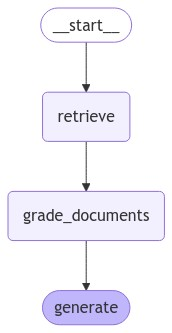

In [105]:
# Create the StateGraph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generate

# Build graph
# Directly set "retrieve" as the entry point, skipping route_question and web_search
workflow.set_entry_point("retrieve")

# Set edges to transition between nodes
workflow.add_edge("retrieve", "grade_documents")  # After retrieving, grade documents
workflow.add_edge("grade_documents", "generate")  # After grading, generate the response

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))


In [119]:
question = {"question": "Give me a list of all pathogens that cause diarrhea you find in the papers", 
            "max_retries": 3}

documents_list = []

for event in graph.stream(question, stream_mode="values"):
    if "generation" in event and isinstance(event["generation"], AIMessage):
        # Print only the content of the AIMessage
        print(event["generation"].content)  
    
    # event contains documents (which are stored under the key 'documents')
    if "documents" in event:
        # append the documents to the documents_list, but do not print them
        documents_list.extend(event["documents"])


---RETRIEVE---
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GRADE: DOCUMENT RELEVANT---
---GENERATE---
The papers mention the following pathogens that cause diarrhea:

1. Rotavirus
2. Microbial agents associated with waterborne diseases (not specified which ones)
3. Other unspecified pathogens mentioned in the references, such as those from Leclerc et al., Kotloff et al., and Platts-Mills et al.

Note that the papers do not provide a comprehensive list of all diarrhea-causing pathogens.


In [120]:
len(documents_list)

12

In [122]:
documents_list

[Document(metadata={'id': '7c20f40e-010e-46f8-8744-7d391aceb159'}, page_content="To be included, a child's diarrhea episode had to be new, acute, and meet at least one clinical criterion for MSD. Clinical criteria included signs of dehydration, dysentery, or hospitalization due to diarrhea. A total of 9,439 out of 14,753 eligible children were enrolled during the study period.\n\nOur analysis focused on pathogens associated with the majority of diarrheal illnesses in GEMS, including rotavirus, Cryptosporidium, Shigella spp., typical EPEC, and ST-ETEC. Additional pathogens such as adenovirus 40/41 and Campylobacter spp. were also included, along with V. cholerae, norovirus GI, and norovirus GII, which were prevalent in multiple sites.\n\n# Results\n\nUsing the aforementioned methods, we characterized the seasonality of multiple enteric pathogens across various study sites and identified associations with environmental factors.\n\n# Conclusion\n\nThis study highlights the importance of u